# Đọc file CSV

**File dữ liệu chưa chuẩn hóa**

In [ ]:
from IPython.display import display
import pandas as pd
data = pd.read_csv('./data_pre.csv')
display(data.head(5))

,Time,Location,MaxTemperature,AvgTemperature,MinTemperature,MaxDewPoint,AvgDewPoint,MinDewPoint,MaxHumidity,AvgHumidity,MinHumidity,MaxWindspeed,AvgWindspeed,MinWindspeed
0,2021-1-1,HoChiMinh,30.0,25.2,23.0,17.0,16.2,16.0,65,57.2,45,12,7.3,5
1,2021-1-2,HoChiMinh,31.0,25.8,22.0,19.0,17.2,16.0,73,59.5,45,12,6.5,2
2,2021-1-3,HoChiMinh,32.0,26.9,22.0,23.0,19.9,17.0,83,67.0,46,7,4.1,0
3,2021-1-4,HoChiMinh,33.0,27.8,24.0,25.0,21.2,18.0,94,70.0,41,10,4.6,1
4,2021-1-5,HoChiMinh,32.0,27.6,24.0,25.0,21.9,19.0,89,72.3,46,9,4.0,1


**File chuẩn hóa dữ liệu**

In [ ]:
df_normal = pd.read_csv('./DataNormal_Maxtemp.csv')
display(df_normal)

,MaxTemperature,AvgTemperature,MinTemperature
0,0.272727,0.208791,0.454545
1,0.363636,0.274725,0.363636
2,0.454545,0.395604,0.363636
3,0.545455,0.494505,0.545455
4,0.454545,0.472527,0.545455
...,...,...,...
876,0.454545,0.351648,0.454545
877,0.454545,0.483516,0.636364
878,0.636364,0.615385,0.818182
879,0.636364,0.670330,0.727273


# Mô hình BiLSTM cho dự đoán MaxTemperature

## Xây dựng và huấn luyện mô hình

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

# Chọn biến
features = ['MaxTemperature','AvgTemperature','MinTemperature']
data_features = df_normal[features].values

# Chọn window
window_size = 7
X_train, y_train = [], []

for i in range(len(data_features) - window_size):
    X_train.append(data_features[i:i + window_size])
    y_train.append(data_features[i + window_size])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Phân chia tập dữ liệu thành tập train và test
split_index = int(0.8 * len(X_train))

X_train, X_test = X_train[:split_index], X_train[split_index:]
y_train, y_test = y_train[:split_index], y_train[split_index:]

# Reshape dữ liệu cho mô hình BiLSTM
X_train = X_train.reshape((X_train.shape[0], window_size, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], window_size, X_test.shape[2]))

In [ ]:
# Xây dựng mô hình BiLSTM
model = Sequential()
model.add(Bidirectional(LSTM(320, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(25))
model.add(Dense(len(features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 7, 640)           829440    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              787456    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 25)                6425      
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                                 
Total params: 1,623,399
Trainable params: 1,623,399
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
22/22 [==============================] - 13s 9ms/step - loss: 0.0495
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0148
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0137
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 5/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 8/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 9/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 10/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 11/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 12/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0120
Epoch 13/100
22/22 [================

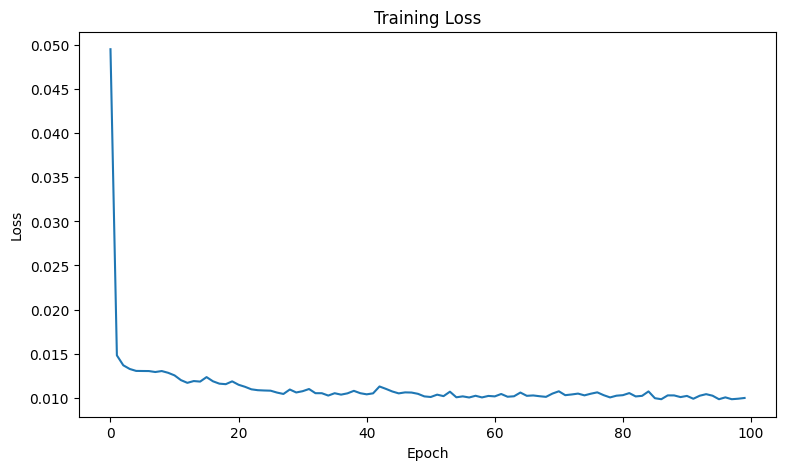

In [ ]:
# Vẽ biểu đồ
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Đánh giá mô hình

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

6/6 [==============================] - 1s 5ms/step
Mean Absolute Error (MAE): 0.07811213929636952
Mean Squared Error (MSE): 0.009848966945776602
R2 Score: 0.6968428544581089


In [ ]:
# Lưu kết quả vào file
results_text = f"Mean Absolute Error (MAE): {mae}\n" \
               f"Mean Squared Error (MSE): {mse}\n" \
               f"R2 Score: {r2}\n"

with open("Result_MaxTempBiLSTM.txt", "w") as file:
    file.write(results_text)

## Vẽ biểu đồ với dữ liệu đã chuẩn hoá

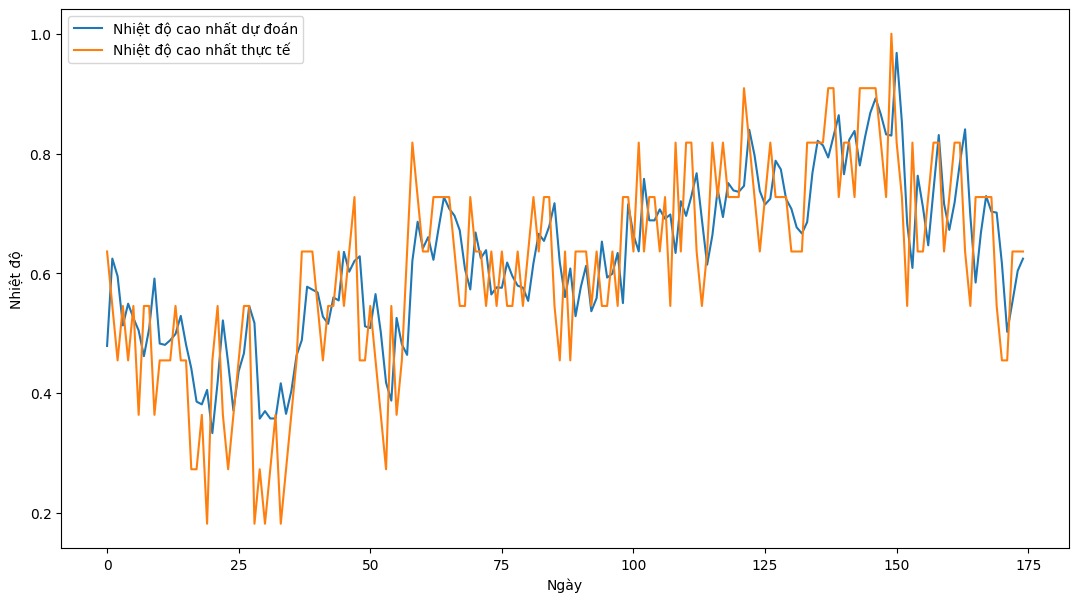

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(13, 7))
plt.plot(y_pred[:,0], label='Nhiệt độ cao nhất dự đoán')
plt.plot(y_test[:,0], label='Nhiệt độ cao nhất thực tế')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ')
plt.legend()
plt.show()

## Vẽ biểu đồ với dữ liệu gốc

*Chuyển đổi dữ liệu dự đoán về dữ liệu gốc*



In [ ]:
# Dữ liệu dự đoán
import sklearn
convert = sklearn.preprocessing.MinMaxScaler()
data_maxtemp = data['MaxTemperature'].values.reshape(-1,1)
convert.fit_transform(data_maxtemp)

# Chuyển đổi dữ liệu
y_pred_original = convert.inverse_transform(y_pred)

print("Dữ liệu dự đoán gốc")
y_pred_original[:10]

Dữ liệu dự đoán gốc


array([[32.266113, 32.00025 , 32.97735 ],
       [33.87012 , 33.451897, 34.0994  ],
       [33.545464, 33.051186, 33.645588],
       [32.641838, 32.095276, 32.87837 ],
       [33.041435, 32.657516, 33.465977],
       [32.77791 , 32.24812 , 32.91786 ],
       [32.548977, 31.587624, 32.019417],
       [32.07672 , 31.485588, 32.29718 ],
       [32.58604 , 31.83341 , 32.340122],
       [33.503075, 33.32048 , 33.911713]], dtype=float32)

In [ ]:
# Chuyển đổi dữ liệu
y_original = convert.inverse_transform(y_test)
print("Dữ liệu thực tế gốc")
y_original[:10]

Dữ liệu thực tế gốc


array([[34.        , 33.40659341, 33.        ],
       [33.        , 32.92307692, 34.        ],
       [32.        , 32.1978022 , 33.        ],
       [33.        , 32.31868132, 33.        ],
       [32.        , 31.95604396, 32.        ],
       [33.        , 31.35164835, 31.        ],
       [31.        , 30.98901099, 32.        ],
       [33.        , 31.71428571, 31.        ],
       [33.        , 33.64835165, 34.        ],
       [31.        , 32.68131868, 34.        ]])

In [ ]:
# Lưu file
df = pd.DataFrame({
    'PreMaxtempBiLSTM': y_pred_original[:,0].flatten(),
})
# Lưu DataFrame vào tệp
df.to_csv('Chart_MaxBiLSTM.csv', index=False)

Vẽ biểu đồ so sánh dữ liệu dự đoán với dữ liệu thực tế

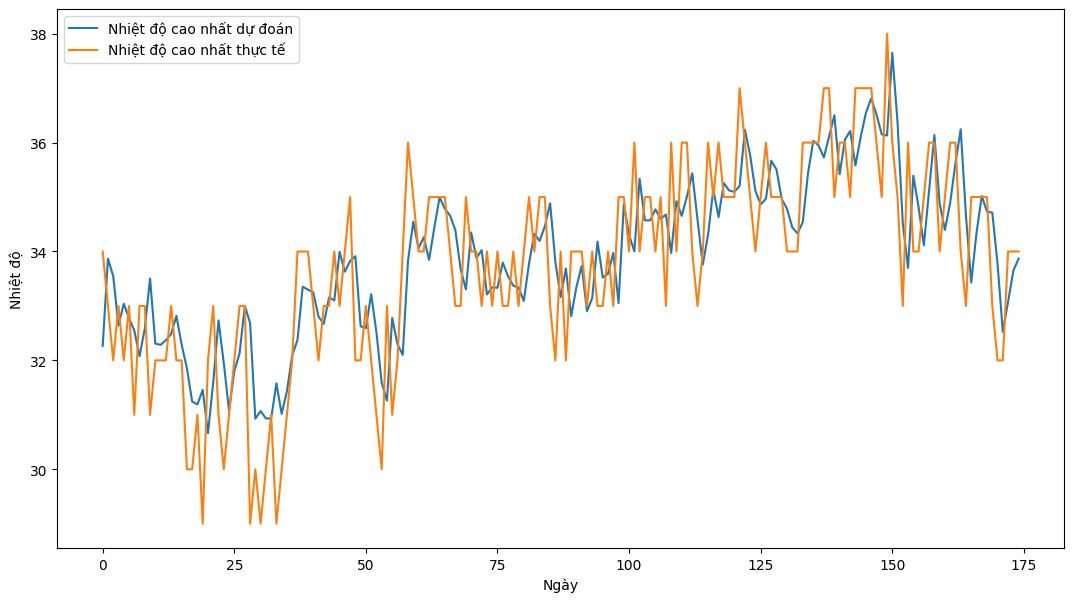

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(13, 7))
plt.plot(y_pred_original[:,0], label='Nhiệt độ cao nhất dự đoán')
plt.plot(y_original[:,0], label='Nhiệt độ cao nhất thực tế')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ')
plt.legend()
plt.show()